# Dimensionality reduction #

is the process of reducing the number of variables under consideration by obtaining a set of principal variables. It can be divided into feature selection and feature extraction.

<ol>
<li>Feature selection approaches try to find a subset of the original features. There are three strategies:</li>
    <ul>
        <li>the filter strategy</li>
        <li>the wrapper strategy</li>
        <li>the embedded strategy</li>
    </ul>
<li>Feature projection transforms the data in the high-dimensional space to a space of fewer dimensions.</li>
</ol>

In this tutorial we will see into the second and we will consider three method of deimenson reduction: **PCA**, **SVD**, **Autoencoder**

## Principal Component Analysis (PCA) ##
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

For illustration of PCA we will use analog of MNIST dataset (handwritten digits) from sklearn.datasets

In [25]:
from sklearn.datasets import load_digits
mnist = load_digits()
mnist.data.shape

(1797, 64)

In this data 64 attributes it will be enough to show PCA usage

Lets split data to train and test

In [26]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_lbl, test_lbl = train_test_split( mnist.data, mnist.target, test_size=0.4, random_state=42)

PCA is effected by scale of data so we need to scale the features in the data before applying PCA. Data can be transformed into unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. StandardScaler helps standardize the dataset’s features.

*Note you fit on the training set only and transform on the training and test set.*

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set
scaler.fit(train_img)
# Apply transform to both
train_img_s = scaler.transform(train_img)
test_img_s = scaler.transform(test_img)

Now we will fit PCA alghoritm the same way as scaler (only on training set) and transform both sets

In [28]:
from sklearn.decomposition import PCA
pca=PCA(.95)

pca.fit(train_img)

train_img_p = pca.transform(train_img)
test_img_p = pca.transform(test_img)

To see how many components were kept check attribute n_components_

In [29]:
pca.n_components_

28

For evaluating influence of usnig PCA lets train simple LR model and compare time of fitting (solver was changed from deafult to 'lbfgs' for speed up training)

In [30]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
%timeit logisticRegr.fit(train_img, train_lbl)

logisticRegr = LogisticRegression(solver = 'lbfgs')
%timeit logisticRegr.fit(train_img_p, train_lbl)

461 ms ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
331 ms ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**How number of kept components will affect on time of model training? Try to change parametr n_components and figure it out.**

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Visualize 64 dimension will be a little difficult, but we can keep only dimension and see what it will lead.

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


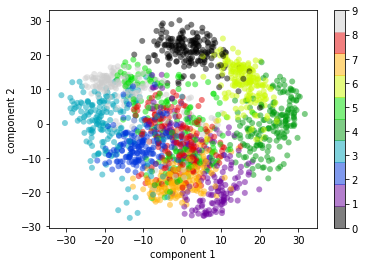

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(2)
projected = pca.fit_transform(mnist.data)
plt.scatter(projected[:, 0], projected[:, 1],
            c=mnist.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

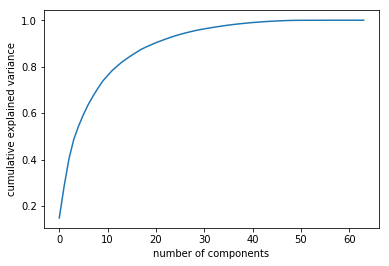

In [33]:
import numpy as np
pca = PCA().fit(mnist.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

Besides *n_components* parametr one more parametr is also importtant: *svd_solver*. There is options that can be set:

* auto :
the solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.

* full :
run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing

* arpack :
run SVD truncated to n_components calling ARPACK solver via scipy.sparse.linalg.svds. It requires strictly 0 < n_components < min(X.shape)

* randomized :
run randomized SVD by the method of Halko et al.

This parametr configure SVD that uses in PCA alghoritm. What is SVD we will find out in next paragraph.

## Singular-Value Decomposition ##

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

For the case of simplicity we will focus on the SVD for real-valued matrices and ignore the case for complex numbers.


$A = U * \sigma * V^T$

Where A is the real *m x n* matrix that we wish to decompose into:
* $U$ is an *m x m* matrix. The columns of this matrix are called the left-singular vectors of $A$.
* $\sigma$ is an *m x n* diagonal matrix. The diagonal values in this matrix are known as the singular values of the original matrix $A$.
* $V^T$ is the  transpose of an *n x n* matrix. The columns of this matrix are called the right-singular vectors of $A$.

Code below shows us simple SVD decomposition

In [34]:
from scipy.linalg import svd

A = [[1, 2, 3], 
     [4, 5, 6],
     [7, 8, 9]]

U, s, VT = svd(A)
print('U = %a' % U)
print('s = %a' % s)
print('VT = %a' % VT)

U = array([[-0.21483724,  0.88723069,  0.40824829],
       [-0.52058739,  0.24964395, -0.81649658],
       [-0.82633754, -0.38794278,  0.40824829]])
s = array([  1.68481034e+01,   1.06836951e+00,   3.33475287e-16])
VT = array([[-0.47967118, -0.57236779, -0.66506441],
       [-0.77669099, -0.07568647,  0.62531805],
       [-0.40824829,  0.81649658, -0.40824829]])


and this reconstructing from $\sigma$. To restore original matrix we need reshape $\sigma$ matrix from *m x m* to *m x n*. To do this create diagonal matrix *m x n*, with values of $\sigma$ matrix on diagonal, and calculate dot product between new sigma matrix and $VT$, and between this result and $U$ matrix.

In [36]:
from numpy import diag
from scipy.linalg import svd

A = [[1, 2, 3], 
     [4, 5, 6],
     [7, 8, 9]]

U, s, VT = svd(A)
print(s)

sigma = diag(s)
print(sigma)

B = U.dot(sigma.dot(VT))
print(B)

[  1.68481034e+01   1.06836951e+00   3.33475287e-16]
[[  1.68481034e+01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.06836951e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   3.33475287e-16]]
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]


For dimensionality reduction we can perform an SVD operation on the original data and select the top k largest singular values in $\sigma$. These columns can be selected from $\sigma$ and the rows selected from $V^T$.

In practice, we can retain and work with a descriptive subset of the data called $T$. This is a dense summary of the matrix or a projection.

Further, this transform can be calculated and applied to the original matrix $A$ as well as other similar matrices.

In [37]:
from numpy import diag
from numpy import dot
from scipy.linalg import svd

A = [[1, 2, 3], 
     [4, 5, 6],
     [7, 8, 9]]

U, s, VT = svd(A)

sigma = diag(s)

n_elements = 2
sigma = sigma[:, :n_elements]
VT = VT[:n_elements, :]

T = dot(U,sigma)
print(T)
T = dot(A,VT.T)
print(T)

[[ -3.6196       0.94789022]
 [ -8.77091014   0.26671199]
 [-13.92222029  -0.41446624]]
[[ -3.6196       0.94789022]
 [ -8.77091014   0.26671199]
 [-13.92222029  -0.41446624]]


The scikit-learn provides a TruncatedSVD class that implements this capability directly.

In [38]:
from sklearn.decomposition import TruncatedSVD

A = [[1, 2, 3], 
     [4, 5, 6],
     [7, 8, 9]]

svd = TruncatedSVD(n_components=2)
svd.fit(A)
result = svd.transform(A)
print(result)

[[  3.6196       0.94789022]
 [  8.77091014   0.26671199]
 [ 13.92222029  -0.41446624]]


We can see that the values match those calculated manually above, except for the sign on some values. We can expect there to be some instability when it comes to the sign given the nature of the calculations involved and the differences in the underlying libraries and methods used. This instability of sign should not be a problem in practice as long as the transform is trained for reuse.

**Try to apply SVD to model from PCA paragraph. Compare influence of both methods. Which one better and why?**

## Autoencoder ##

What is an autoencoder?

An autoencoder is an unsupervised machine learning algorithm that takes some data as input and reconstructs it using fewer number of bits. That may sound like compression, but the biggest difference between an autoencoder and a general purpose compression algorithms is that in case of autoencoders, the compression is achieved by learning on a training set of data. While reasonable compression is achieved when the data is similar to the training set used.

Autoencoders are similar in spirit to dimensionality reduction techniques like principal component analysis (PCA). They create a space where the essential parts of the data are preserved, while non-essential ( or noisy ) parts are removed.

There are two parts to an autoencoder:
* **Encoder**: This is the part of the network that compresses the input into a fewer number of bits. The space represented by these fewer number of bits is called the “latent-space” and the point of maximum compression is called the bottleneck. These compressed bits that represent the original input are together called an “encoding” of the input.
* **Decoder**: This is the part of the network that reconstructs the input data using the encoding of the data.

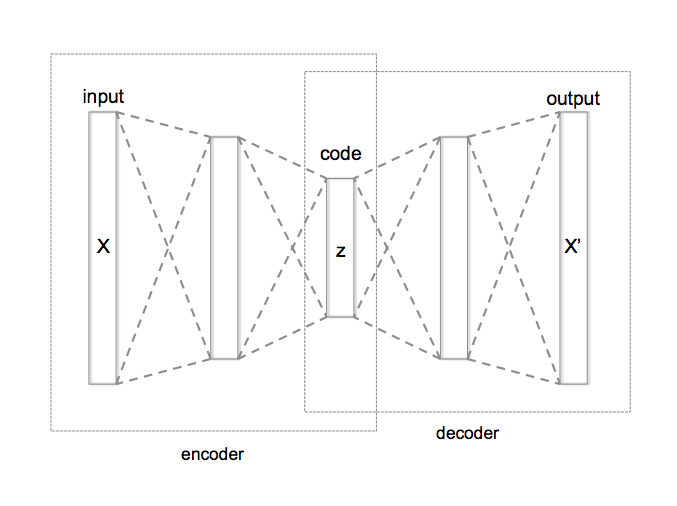

For example we will train simple tensorflow network for digits classification on the data we used when consider PCA.

**You need install tensorflow package for this paragraph**

Use pip for install tensorflow. Execute this command from terminal or cmd:

*pip install tensorflow*

In [39]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

We will be use MNIST dataset for examples. Download dataset from kaggle: https://www.kaggle.com/c/digit-recognizer/download/train.csv

In [40]:
mnist = pd.read_csv('mnist.csv')
data = mnist.drop(['label'], axis=1)
target = mnist['label']
data.shape

(42000, 784)

There are we have 42000 image, *28 x 28* pixels

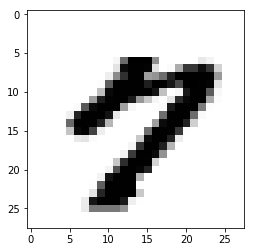

7


In [41]:
plt.imshow(data.iloc[666].values.reshape(28,28), cmap='Greys')
plt.show()
print(target[666])

Now lets build the autoencoder itself.

As we remember input and output layers have the same shape and it equal to shape of original image. An image goes in, same image comes out. Here, an image is an array of length 784. So, the input and the output layer should have 784 nodes. Now we have the choice of deciding how many hidden layers there should be and what they’d look like. For this example we won't be make it to complicated and just put two hidden layers which have 32 nodes each. Here the first two layer make up the encoder and the last two are the decoder.

In [42]:
n_nodes_inpl = 784  #encoder
n_nodes_hl1  = 32  #encoder

n_nodes_hl2  = 32  #decoder
n_nodes_outl = 784  #decoder

After that we need to assign random values to the weights and biases associated to the different layers of our model.

For this example, *tf.random_normal( [n_nodes_inpl,n_nodes_hl1])* is a *784 x 32* weight matrix and *tf.random_normal( [n_nodes_hl1] )* is a bias matrix. All weights and biases will be updated continuosly as we train the model.

*Note: in a fully connected neural net, if first layer has m nodes and second layer has n nodes, then their connection has m x n weights and n biases. Remember that when you want to change the network configuration.*

In [43]:
# hidden layer with 784*32 weights and 32 biases
hidden_1_layer_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_inpl,n_nodes_hl1])),
    'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))  }
# hidden layer with 32*32 weights and 32 biases
hidden_2_layer_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
    'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))  }
# hidden layer with 32*784 weights and 784 biases
output_layer_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_outl])),
    'biases':tf.Variable(tf.random_normal([n_nodes_outl])) }

Now we will define the whole neural net.

In [44]:
# image with shape 784 goes in
input_layer = tf.placeholder('float', [None, 784])

# multiply output of input_layer wth a weight matrix and add biases
layer_1 = tf.nn.sigmoid(
       tf.add(tf.matmul(input_layer,hidden_1_layer_vals['weights']),
       hidden_1_layer_vals['biases']))

# multiply output of layer_1 wth a weight matrix and add biases
layer_2 = tf.nn.sigmoid(
       tf.add(tf.matmul(layer_1,hidden_2_layer_vals['weights']),
       hidden_2_layer_vals['biases']))

# multiply output of layer_2 wth a weight matrix and add biases
output_layer = tf.matmul(layer_2,output_layer_vals['weights']) + output_layer_vals['biases']

# output_true shall have the original image for error calculations
output_true = tf.placeholder('float', [None, 784])

# define cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))

# define optimizer
learn_rate = 0.1   # how fast the model should learn
optimizer = tf.train.AdamOptimizer(learn_rate).minimize(meansq)

Let's see what is going on here — we are iteratively multiplying the output of each layer with the corresponding weight matrix , adding the bias to it and then taking it through the activation function— for example, *tf.matmul( input_layer, hidden_1_layer_vals[‘weights’] )* multiplies the input_layer with a *784 x 32* weight matrix, adds the *32 x 1* bias matrix to it, and then takes it through the sigmoid function.

*input_layer* and *output_true* are just placeholders here. It means we can tell the model what these should hold when we run it. And these are supposed to hold the images that we put into the model. So an image goes into the *input_layer* and comes out of the *output_layer*. Then we will compare this to output_true which will have the original image. We’ll use MSE as a cost function and sigmoid as an activation function for both the hidden layers.

Now we can run it and check results.

In [45]:
# initialising and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# defining batch size, number of epochs and learning rate
batch_size = 100  # how many images to use together for training
hm_epochs = 10    # how many times to go through the entire dataset
tot_images = data.shape[0] # total number of images
# running the model for a 10 epochs taking 100 images in batches
# total improvement is printed out after each epoch
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0
    for i in range(int(tot_images/batch_size)):
        epoch_x = data[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],\
               feed_dict={input_layer: epoch_x, \
               output_true: epoch_x})
        epoch_loss += c
    print('Epoch', epoch+1, '/', hm_epochs, 'loss:',epoch_loss)

Epoch 1 / 10 loss: 1876196.46997
Epoch 2 / 10 loss: 1836515.60303
Epoch 3 / 10 loss: 1785007.9397
Epoch 4 / 10 loss: 1759794.84497
Epoch 5 / 10 loss: 1758520.65796
Epoch 6 / 10 loss: 1752895.17603
Epoch 7 / 10 loss: 1744689.41431
Epoch 8 / 10 loss: 1743382.54126
Epoch 9 / 10 loss: 1709068.10205
Epoch 10 / 10 loss: 1694402.0022


It works!
Now let's take a look on coed. There are two loops in the code. The outer one is for the epoch i.e. one loop means you’ve gone through the whole dataset once. And the inner loop is for batching, where you pass 100 images in batches to train the network, until you’ve gone through the whole dataset once. Every time you run the optimizer, all the weights and variables get updated in your network. Also after every epoch the progress printed out.

**A 10 epochs does not take a lot of time. Try with a bit more if your computer allows.**

Now we can see how encoding looks like for one image.

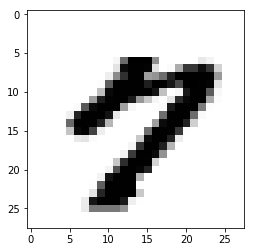

[[ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.
   1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.]]


In [46]:
# pick any image
val_image = data.iloc[666].values
# run it though the autoencoder
output_val_image = sess.run(output_layer,\
                   feed_dict={input_layer:[val_image]})
# run it though just the encoder
encoded_val_image = sess.run(layer_1,\
                   feed_dict={input_layer:[val_image]})
# print the original image
plt.imshow(val_image.reshape(28,28),  cmap='Greys')
plt.show()
# print the encoding
print(encoded_val_image)

In this paragrapth i didnt validate my model against a test set here, which i should.

**Try it for yourself. Change number of epochs, shape of second layer or use completely new dataset. Compare results and explain it**